[View in Colaboratory](https://colab.research.google.com/github/aseria/mlcc/blob/test/logistic_regression/logistic_regression.ipynb)

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 로지스틱 회귀

 **학습 목표:**
  * 이전 실습의 주택 가격 중간값 예측 모델을 이진 분류 모델로 재편한다
  * 이진 분류 문제에서 로지스틱 회귀와 선형 회귀의 효과를 비교한다

 이전 실습과 동일하게 캘리포니아 주택 데이터 세트를 사용하되, 이번에는 특정 지역의 거주 비용이 높은지 여부를 예측하는 이진 분류 문제로 바꿔 보겠습니다. 또한 기본 특성으로 일단 되돌리겠습니다.

 ## 이진 분류 문제로 전환

데이터 세트의 타겟은 숫자(연속 값) 특성인 `median_house_value`입니다. 이 연속 값에 임계값을 적용하여 부울 라벨을 만들 수 있습니다.

특정 지역을 나타내는 특성이 주어질 때 거주 비용이 높은 지역인지를 예측하려고 합니다. 데이터 학습 및 평가를 위한 타겟을 준비하기 위해, 분류 임계값을 주택 가격 중앙값에 대한 75번째 백분위수(약 265,000)로 정의하겠습니다. 주택 가격이 임계값보다 높으면 라벨이 `1`로, 그렇지 않으면 라벨이 `0`으로 지정됩니다.

 ## 설정

아래 셀을 실행하여 데이터를 로드하고 입력 특성 및 타겟을 준비합니다.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

 아래 코드가 이전 실습에 비해 다른 점을 확인하세요. `median_house_value`를 타겟으로 사용하는 대신 `median_house_value_is_high`라는 이진 타겟을 새로 만들고 있습니다.

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # medianHouseValue is above a set threshold.
  output_targets["median_house_value_is_high"] = (
    california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

In [3]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2631.1,536.1,1420.0,497.9,3.9,2.0
std,2.1,2.0,12.6,2149.8,419.1,1157.7,381.2,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1459.8,295.0,783.0,280.0,2.6,1.5
50%,34.2,-118.5,29.0,2115.0,430.5,1158.0,406.0,3.6,1.9
75%,37.7,-118.0,37.0,3137.0,643.0,1715.0,599.2,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2673.8,547.3,1452.6,509.2,3.9,2.0
std,2.1,2.0,12.5,2250.7,427.1,1123.6,392.3,1.9,1.1
min,32.5,-124.3,2.0,11.0,3.0,13.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1469.8,301.0,809.0,284.0,2.5,1.5
50%,34.3,-118.5,28.0,2160.5,442.0,1190.0,416.5,3.5,1.9
75%,37.7,-118.0,37.0,3175.8,661.0,1738.5,616.0,4.7,2.3
max,41.9,-114.6,52.0,37937.0,5471.0,16122.0,5189.0,15.0,27.1


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


 ## 선형 회귀의 성능 측정
로지스틱 회귀가 효과적인 이유를 확인하기 위해, 우선 선형 회귀를 사용하는 단순 모델을 학습시켜 보겠습니다. 이 모델에서는 `{0, 1}` 집합에 속하는 값을 갖는 라벨을 사용하며 `0` 또는 `1`에 최대한 가까운 연속 값을 예측하려고 시도합니다. 또한 출력을 확률로 해석하려고 하므로 `(0, 1)` 범위 내에서 출력되는 것이 이상적입니다. 그런 다음 임계값 `0.5`를 적용하여 라벨을 결정합니다.

아래 셀을 실행하여 [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/contrib/learn/LinearRegressor)로 선형 회귀 모델을 학습시킵니다.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_linear_regressor_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 0.45
  period 01 : 0.44
  period 02 : 0.51
  period 03 : 0.63
  period 04 : 0.45
  period 05 : 0.45
  period 06 : 0.47
  period 07 : 0.43
  period 08 : 0.46
  period 09 : 0.43
Model training finished.


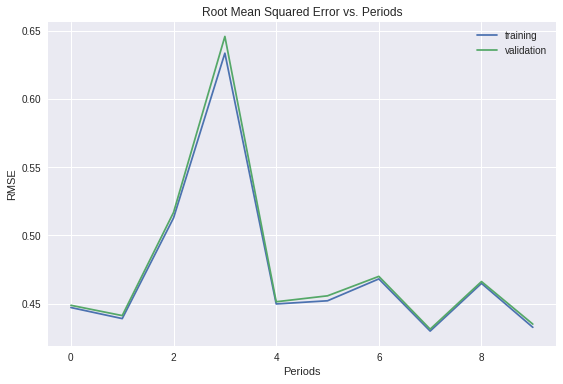

In [11]:
##################################################################### MY CODE HERE #####################################################################
linear_regressor = train_linear_regressor_model(
    learning_rate=0.00001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 0.45
  period 01 : 0.45
  period 02 : 0.44
  period 03 : 0.44
  period 04 : 0.44
  period 05 : 0.44
  period 06 : 0.44
  period 07 : 0.44
  period 08 : 0.44
  period 09 : 0.44
Model training finished.


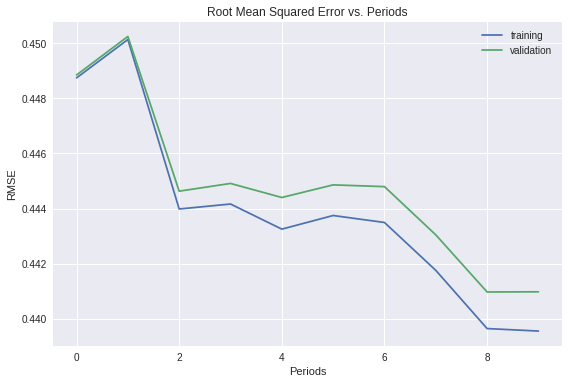

In [12]:
# 기존 코드
linear_regressor = train_linear_regressor_model(
    learning_rate=0.000001,
    steps=200,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 0.45
  period 01 : 0.45
  period 02 : 0.44
  period 03 : 0.44
  period 04 : 0.44
  period 05 : 0.44
  period 06 : 0.44
  period 07 : 0.44
  period 08 : 0.44
  period 09 : 0.44
Model training finished.


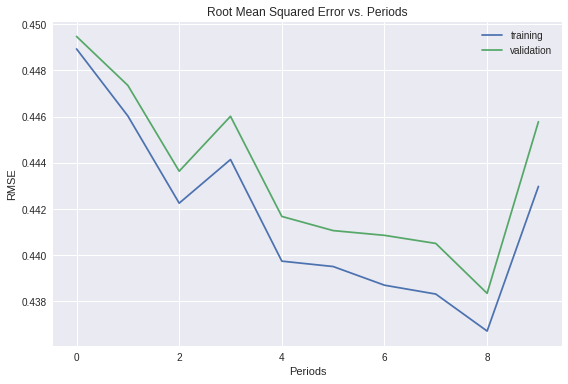

In [13]:
##################################################################### MY CODE HERE #####################################################################
linear_regressor = train_linear_regressor_model(
    learning_rate=0.000001,
    steps=600,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 작업 1: 예측의 LogLoss 계산 가능성 확인

**예측을 조사하여 LogLoss를 계산하는 데 사용될 수 있는지 확인합니다.**

`LinearRegressor`는 L2 손실을 사용하므로 출력이 확률로 해석되는 경우 오분류에 효과적으로 페널티를 부여하지 못합니다. 예를 들어 음성 예가 양성으로 분류되는 확률이 0.9인 경우와 0.9999인 경우에는 커다란 차이가 있어야 하지만 L2 손실은 두 경우를 분명하게 구분하지 않습니다.

반면, `LogLoss`는 이러한 "신뢰 오차"에 훨씬 큰 페널티를 부여합니다.  `LogLoss`는 다음과 같이 정의됩니다.

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$


하지만 우선 예측 값을 가져오는 것이 먼저입니다. `LinearRegressor.predict`를 사용하여 값을 가져올 수 있습니다.

예측과 타겟이 주어지면 `LogLoss`를 계산할 수 있는지 확인해 보세요.

In [0]:
##################################################################### MY CODE HERE #####################################################################
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

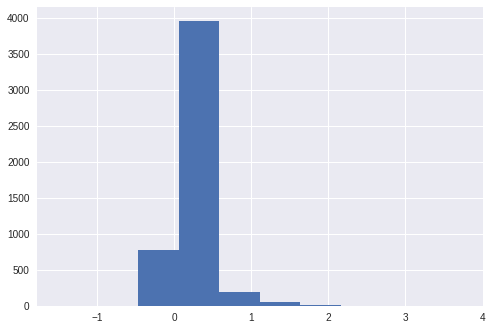

In [18]:
_ = plt.hist(validation_predictions)

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.

In [0]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

_ = plt.hist(validation_predictions)

 ## 작업 2: 로지스틱 회귀 모델을 학습시키고 검증세트로 LogLoss 계산

로지스틱 회귀를 사용하려면 `LinearRegressor` 대신 [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier)를 사용합니다. 아래 코드를 완성하세요.

**NOTE**: `LinearClassifier` 모델에서 `train()` 및 `predict()`를 실행할 때는 반환된 dict의 `"probabilities"` 키를 통해 예측된 실수값 확률에 액세스할 수 있습니다(예: `predictions["probabilities"]`). Sklearn의 [log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) 함수를 사용하면 이러한 확률로 LogLoss를 편리하게 계산할 수 있습니다.


In [0]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of one feature.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  ############################################ YOUR CODE HERE: Construct the linear classifier. ############################################
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.59
  period 01 : 0.57
  period 02 : 0.56
  period 03 : 0.56
  period 04 : 0.54
  period 05 : 0.54
  period 06 : 0.53
  period 07 : 0.53
  period 08 : 0.53
  period 09 : 0.52
Model training finished.


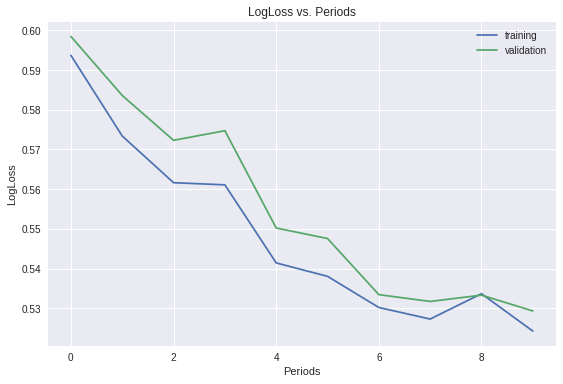

In [21]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### 해결 방법

해결 방법을 보려면 아래를 클릭하세요.



In [0]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of one feature.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear classifier object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)  
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

In [0]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 작업 3: 검증 세트로 정확성 계산 및 ROC 곡선 도식화

분류에 유용한 몇 가지 측정항목은 모델 [정확성](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), [ROC 곡선](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) 및 AUC(ROC 곡선 아래 영역)입니다. 이러한 측정항목을 조사해 보겠습니다.

`LinearClassifier.evaluate`는 정확성 및 AUC 등의 유용한 측정항목을 계산합니다.

In [22]:
evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.74
Accuracy on the validation set: 0.76


 `LinearClassifier.predict` 및 Sklearn의 [roc_curve](http://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 등으로 계산되는 클래스 확률을 사용하여 ROC 곡선을 도식화하는 데 필요한 참양성률 및 거짓양성률을 가져올 수 있습니다.

In [23]:
validation_targets.describe()

,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


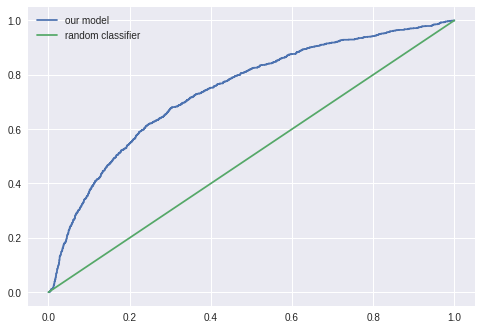

In [24]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

 **작업 2에서 학습시킨 모델의 학습 설정을 조정하여 AUC를 개선할 수 있는지 확인해 보세요.**

어떤 측정항목을 개선하면 다른 측정항목이 악화되는 경우가 종종 나타나므로, 적절하게 균형이 맞는 설정을 찾아야 합니다.

**모든 측정항목이 동시에 개선되는지 확인해 보세요.**

Training model...
LogLoss (on training data):
  period 00 : 0.51
  period 01 : 0.50
  period 02 : 0.48
  period 03 : 0.48
  period 04 : 0.47
  period 05 : 0.47
  period 06 : 0.47
  period 07 : 0.47
  period 08 : 0.47
  period 09 : 0.47
Model training finished.
AUC on the validation set: 0.80
Accuracy on the validation set: 0.78


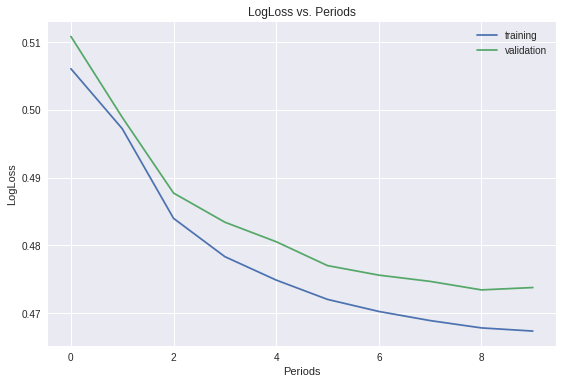

In [26]:
# TUNE THE SETTINGS BELOW TO IMPROVE AUC
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=10000, #200 -> 10000 더 많은 학습?
    batch_size=200, # 20 -> 100 batch내 데이터 분포 고르게
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

 ### 해결 방법

가능한 해결 방법을 보려면 아래를 클릭하세요.

 효과적인 해결 방법 중 하나는 과적합이 나타나지 않는 범위 내에서 더 오랫동안 학습하는 것입니다. 

이렇게 하려면 단계 수, 배치 크기 또는 둘 모두를 늘리면 됩니다.

모든 측정항목이 동시에 개선되므로 손실 측정항목은 AUC와 정확성 모두를 적절히 대변합니다.

AUC를 몇 단위만 개선하려 해도 굉장히 많은 추가 반복이 필요합니다. 이는 흔히 나타나는 상황이지만, 이렇게 작은 개선이라도 비용을 투자할 가치는 충분합니다.

Training model...
LogLoss (on training data):
  period 00 : 0.49
  period 01 : 0.48
  period 02 : 0.47
  period 03 : 0.47
  period 04 : 0.47
  period 05 : 0.47
  period 06 : 0.47
  period 07 : 0.46
  period 08 : 0.46
  period 09 : 0.47
Model training finished.
AUC on the validation set: 0.81
Accuracy on the validation set: 0.78


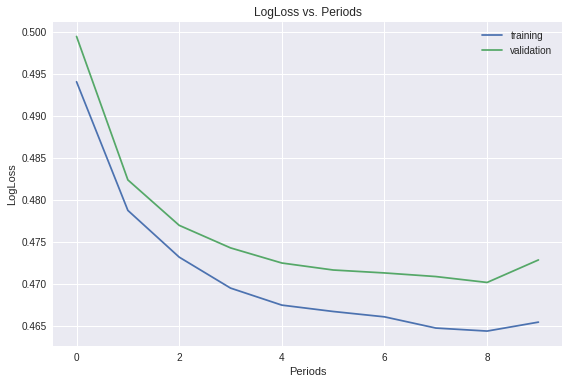

In [27]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000003,
    steps=20000,
    batch_size=500,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])